In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib_scalebar.scalebar import ScaleBar
from tqdm import tqdm
import numpy as np
from datetime import datetime
from geopy.point import Point
from geopy.distance import geodesic


In [157]:
# Establish directory locations

parent_dir    = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir      = os.path.join(parent_dir, 'data')
satellite_dir = os.path.join(data_dir, 'satellite')
output_dir    = os.path.join(parent_dir, 'Output')
pos_data_dir  = os.path.join(parent_dir, 'Plotting_tools/shared_data')

In [158]:
all_positions = pd.read_csv(os.path.join(pos_data_dir, 'rt_positions.csv'))
all_positions['datetime'] = pd.to_datetime(all_positions['date'])
all_positions['date'] = all_positions['datetime'].apply(lambda x: x.strftime('%m-%d %H:%M'))

In [159]:
lovuse31 = all_positions[all_positions['platform_id'] == 'lovuse031c']

In [160]:
platform_mask = {
        'Ship':  'x',
        'glider': '^',
        'Float':  'o',
        'respire': '>',
        'waypoint': '1'}

platform_colors = {
        'Discovery':  'black',
        'unit_405': '#b2182b',
        'unit_397':  '#f4a582',
        'unit_398': '#d6604d',
        'unit_345': '#fddbc7',
        'lovuse031c': '#92c5de',
        'lovuse032c': '#4393c3',
        'lovuse026d': '#2166ac',
        'respire': '#b8e186',
        'waypoint 1': 'black',
        'waypoint 2': 'black',
        'waypoint 3': 'black',
        'waypoint 4': 'black'}

def get_color(platform_id):
    return platform_colors.get(platform_id, 'black')

all_positions['color'] = all_positions['platform_id'].apply(get_color)

In [161]:
autonomy_positions = all_positions[all_positions['platform_type'].isin(['glider', 'Float', 'waypoint'])]

In [162]:
max_lon = autonomy_positions['lon'].max() + 0.05
min_lon = autonomy_positions['lon'].min() - 0.05
max_lat = autonomy_positions['lat'].max() + 0.05
min_lat = autonomy_positions['lat'].min() - 0.05


In [163]:
positions = all_positions.loc[all_positions.groupby('platform_id')['date'].idxmax()]

In [164]:

current_time = datetime.now()
now = current_time.strftime(format = '%Y-%m-%d %H:%M:%S')

In [165]:
positions_from_start = all_positions[all_positions['datetime'] > pd.to_datetime('2024-06-05 10:00:01')]

In [166]:
floats_positions = all_positions[all_positions['platform_type'] == 'Float']

In [167]:
dates_of_gliders = positions_from_start[positions_from_start['platform_type'].isin(['glider', 'Float'])]['datetime'].unique()

In [168]:
current = pd.read_csv(os.path.join(data_dir, 'Gliders/current.csv'))
current['datetime'] = current['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x / 1000))
current_position = current[current['variable'].isin(['m_lon', 'm_lat'])]
current_x = current[current['variable'] == 'm_water_vx']
current_y = current[current['variable'] == 'm_water_vy']
current_position = current_position.pivot_table(index='datetime', columns='variable', values='value').reset_index()
current_x =  current_x.pivot_table(index='datetime', columns='variable', values='value').reset_index()
current_y =  current_y.pivot_table(index='datetime', columns='variable', values='value').reset_index()


# Ensure both DataFrames are sorted by the datetime column
current_position = current_position.sort_values('datetime')
current_x = current_x.sort_values('datetime')
current_y = current_y.sort_values('datetime')

# Perform the asof merge
merged_df = pd.merge_asof(current_x, current_y, on='datetime', direction='nearest')
merged_df = pd.merge_asof(merged_df, current_position, on='datetime', direction='nearest')

C:\Users\flapet\AppData\Local\Temp\ipykernel_18232\851133877.py:2: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  current['datetime'] = current['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x / 1000))


In [169]:
for i in tqdm(dates_of_gliders):
    temp = all_positions[all_positions['datetime']<= pd.to_datetime(i)]
    temp = temp.loc[temp.groupby('platform_id')['datetime'].idxmax()]
    datename = i.strftime(format = '%Y-%m-%d %H:%M:%S').replace(" ", "_").replace(":", "").replace("-", "")
    filename = parent_dir + '/Output/Plots/rt_tracking/rt_tracking_' + datename + '.png'

    temp_current = merged_df[merged_df['datetime']<= pd.to_datetime(i)]
    x = temp_current['m_lon']
    y = temp_current['m_lat']
    u = temp_current['m_water_vx']
    v = temp_current['m_water_vy']

    speed = np.sqrt(u**2 + v**2)
    dist = speed * 60 * 60 * 6


    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

                        # Set the map extent based on your latitude and longitude ranges
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())


    for platform_type, mask in platform_mask.items():
        subset = temp[temp['platform_type'] == platform_type]
        for platform_id, color in platform_colors.items():
            sub_subset = subset[subset['platform_id'] == platform_id]
            if not sub_subset.empty:
                ax.scatter(sub_subset['lon'], sub_subset['lat'], c=color, label=platform_id, marker=mask, s=100, transform=ccrs.PlateCarree())
                for index, row in sub_subset.iterrows():
                    ax.annotate(str(row['date']), (row['lon'], row['lat']), transform=ccrs.PlateCarree())

    ax.scatter(-24, 60, label = 'Station 1', marker = 'X', c = 'Black', transform = ccrs.PlateCarree(), s = 200)
    im = ax.quiver(x, y, u, v, speed, angles='xy', scale_units='xy', cmap='viridis', transform=ccrs.PlateCarree(), width = 0.002)


    # Add a scale bar
    ax.add_artist(ScaleBar(1, location = "lower left"))

    # Add gridlines and labels
    gl = ax.gridlines(draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    gl.top_labels=False   # suppress top labels
    gl.right_labels=False # suppress right labels

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Platform Positions \n {i}')
    # Shink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    plt.legend(title='Platform ID', bbox_to_anchor=(1.05, 1), borderaxespad=0., loc='upper left')  # Adjust the coordinates as needed

    cbar = plt.colorbar(im, ax = ax, label=r'Depth averaged current (m s$^{-1}$)', location='bottom')
    cbar.set_label(r'Depth averaged current (m s$^{-1}$)', labelpad=15)

    plt.savefig(filename)
    plt.close()


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


In [199]:

# Calculate distance traveled over 6 hours for each speed
merged_df['speed'] = np.sqrt(merged_df['m_water_vx']**2 + merged_df['m_water_vy']**2)
merged_df['distance_6h'] = merged_df['speed'] * 60 * 60 * 12 / 1000  # distance in km

def calculate_bearing(dx, dy):
    angle = np.arctan2(dx, dy)  # angle in radians
    bearing = np.degrees(angle)  # convert to degrees
    bearing = (bearing + 360) % 360  # normalize to 0-360
    return bearing

# Calculate bearings
merged_df['bearing'] = merged_df.apply(lambda row: calculate_bearing(row['m_water_vx'], row['m_water_vy']), axis=1)


# Function to calculate new position based on initial position and distance
def new_position(lat, lon, distance_km, bearing):
    origin = Point(lat, lon)
    destination = geodesic(kilometers=distance_km).destination(origin, bearing)
    return destination.latitude, destination.longitude

# Calculate new positions
new_positions = [new_position(row.m_lat, row.m_lon, row.distance_6h, row.bearing)
                 for row in merged_df.itertuples()]

# Add new positions to dataframe
merged_df['new_latitude'], merged_df['new_longitude'] = zip(*new_positions)

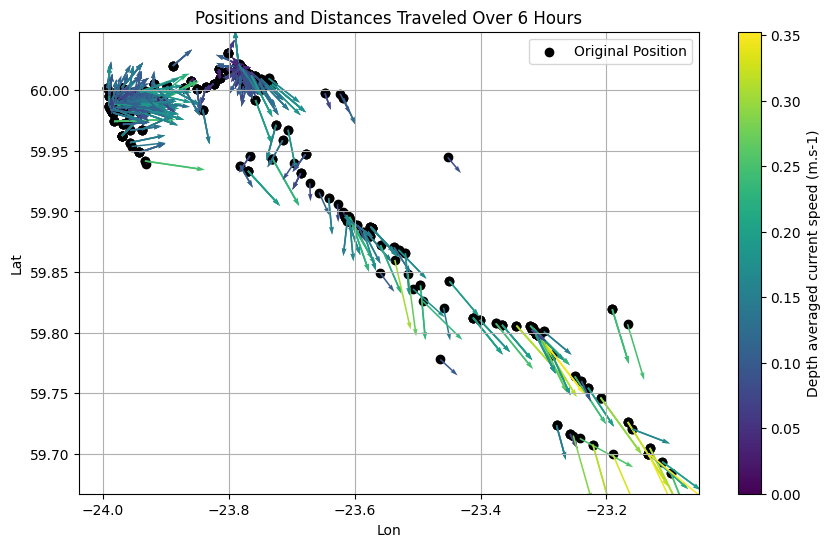

In [207]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Normalize the speed values for the color map
norm = mcolors.Normalize(vmin=merged_df['speed'].min(), vmax=merged_df['speed'].max())
cmap = cm.viridis  # You can choose any colormap you like
fig, ax = plt.subplots(figsize=(10, 6))
# Scatter plot for original positions colored by speed
plt.scatter(merged_df['m_lon'], merged_df['m_lat'], label='Original Position', c = 'black')


# Calculate the change in position
d_lon = merged_df['new_longitude'] - merged_df['m_lon']
d_lat = merged_df['new_latitude'] - merged_df['m_lat']

# Plot arrows
quiver = ax.quiver(merged_df['m_lon'], merged_df['m_lat'], d_lon, d_lat,
           merged_df['speed'], cmap=cmap, scale=1, scale_units='xy', angles='xy', width=0.0025)

# Adding color bar
cbar = fig.colorbar(quiver, ax=ax)
cbar.set_label('Depth averaged current speed (m.s-1)')

plt.xlabel('Lon')
plt.ylabel('Lat')
plt.title('Positions and Distances Traveled Over 6 Hours')
plt.legend()
plt.grid(True)
plt.show()

In [212]:
for i in tqdm(dates_of_gliders):
    temp = all_positions[all_positions['datetime']<= pd.to_datetime(i)]
    temp = temp.loc[temp.groupby('platform_id')['datetime'].idxmax()]
    datename = i.strftime(format = '%Y-%m-%d %H:%M:%S').replace(" ", "_").replace(":", "").replace("-", "")
    filename = parent_dir + '/Output/Plots/rt_tracking/rt_tracking_' + datename + '.png'

    temp_current = merged_df[merged_df['datetime']<= pd.to_datetime(i)]
    x = temp_current['m_lon']
    y = temp_current['m_lat']
    u = temp_current['m_water_vx']
    v = temp_current['m_water_vy']

    speed = np.sqrt(u**2 + v**2)
    dist = speed * 60 * 60 * 6


    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

                        # Set the map extent based on your latitude and longitude ranges
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())


    for platform_type, mask in platform_mask.items():
        subset = temp[temp['platform_type'] == platform_type]
        for platform_id, color in platform_colors.items():
            sub_subset = subset[subset['platform_id'] == platform_id]
            if not sub_subset.empty:
                ax.scatter(sub_subset['lon'], sub_subset['lat'], c=color, label=platform_id, marker=mask, s=100, transform=ccrs.PlateCarree())
                for index, row in sub_subset.iterrows():
                    ax.annotate(str(row['date']), (row['lon'], row['lat']), transform=ccrs.PlateCarree())

    ax.scatter(-24, 60, label = 'Station 1', marker = 'X', c = 'Black', transform = ccrs.PlateCarree(), s = 200)
    #im = ax.quiver(x, y, u, v, speed, angles='xy', scale_units='xy', cmap='viridis', transform=ccrs.PlateCarree(), width = 0.002)
    d_lon = merged_df['new_longitude'] - merged_df['m_lon']
    d_lat = merged_df['new_latitude'] - merged_df['m_lat']

    # Plot arrows
    quiver = ax.quiver(merged_df['m_lon'], merged_df['m_lat'], d_lon, d_lat,
           merged_df['speed'], cmap=cmap, scale=1, scale_units='xy', angles='xy', width=0.0025, transform = ccrs.PlateCarree())


    # Add a scale bar
    ax.add_artist(ScaleBar(1, location = "lower left"))

    # Add gridlines and labels
    gl = ax.gridlines(draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    gl.top_labels=False   # suppress top labels
    gl.right_labels=False # suppress right labels

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Platform Positions \n {i}')
    # Shink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    plt.legend(title='Platform ID', bbox_to_anchor=(1.05, 1), borderaxespad=0., loc='upper left')  # Adjust the coordinates as needed

    cbar = plt.colorbar(quiver, ax = ax, label=r'Depth averaged current (m s$^{-1}$)', location='bottom')
    cbar.set_label(r'Depth averaged current (m s$^{-1}$)', labelpad=15)

    plt.savefig(filename)
    plt.close()

100%|██████████| 3/3 [00:05<00:00,  1.97s/it]
